In [0]:
import os
import shutil
from sklearn.utils import shuffle
import numpy as np
import json
import cv2
import matplotlib.pyplot as plt

In [0]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras.utils.np_utils import to_categorical
from keras.layers import *
from keras import backend as K
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications import ResNet50, VGG19, InceptionResNetV2, InceptionV3, DenseNet201
from keras.applications.xception import Xception
from keras.callbacks import *
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import re
from keras.datasets import mnist

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
ROW = 28
COL = 28
CHANNEL = 1
img_shape = (ROW, COL, CHANNEL)
z_dim = 100

### VERY SIMPLE GAN

In [0]:
from keras.layers.advanced_activations import LeakyReLU
def build_generator(img_shape, z_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(ROW*COL, activation='tanh'))
    model.add(Reshape(img_shape))
    return model
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [0]:
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

#### ALWAY freeze discriminator

In [ ]:
def train_freeze_discriminator(interations, batch_size, sample_interval):
    losses = []
    accuracies = []
    iteration_checkpoints = []
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train / 127.5 - 1
    print(X_train.shape)
    X_train = np.expand_dims(X_train, axis=3)
    print(X_train.shape)
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    generator = build_generator(img_shape, z_dim)

    discriminator = build_discriminator(img_shape)
    discriminator.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
    discriminator.trainable = False

    gan = build_gan(generator, discriminator)
    gan.compile(loss='binary_crossentropy', optimizer='Adam')

    for iteration in range(interations):
        # train discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # train generator
        z = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(z, real)
    
        if(iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration+1)

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                      (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            sample_images(generator)
      

In [0]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
  
    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

(60000, 28, 28)
(60000, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5000 [D loss: 0.273714, acc.: 89.45%] [G loss: 4.944351]
10000 [D loss: 0.374168, acc.: 81.64%] [G loss: 3.606751]
15000 [D loss: 0.416967, acc.: 83.20%] [G loss: 2.987459]
20000 [D loss: 0.396007, acc.: 82.42%] [G loss: 2.541887]
25000 [D loss: 0.340889, acc.: 84.77%] [G loss: 2.938191]
30000 [D loss: 0.415497, acc.: 81.25%] [G loss: 2.169827]
35000 [D loss: 0.429021, acc.: 78.91%] [G loss: 1.983436]
40000 [D loss: 0.511100, acc.: 77.73%] [G loss: 2.178665]
45000 [D loss: 0.427569, acc.: 77.73%] [G loss: 2.370267]
50000 [D loss: 0.473386, acc.: 77.73%] [G loss: 2.254374]
55000 [D loss: 0.471302, acc.: 78.12%] [G loss: 2.323887]
60000 [D loss: 0.334926, acc.: 84.38%] [G loss: 2.299961]
65000 [D loss: 0.409157, acc.: 82.81%] [G loss: 2.210658]
70000 [D loss: 0.375243, acc.: 82.03%] [G loss: 2.357497]
75000 [D loss: 0.377075, acc.: 83.20%] [G loss: 2.137394]
80000 [D loss: 0.452872, acc.: 79.69%] [G loss: 2.141964]
85000 [D loss: 0.400984, acc.: 82.42%] [G loss: 2.272228]
90000 [D loss: 

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


110000 [D loss: 0.340149, acc.: 84.77%] [G loss: 2.761328]
115000 [D loss: 0.496976, acc.: 77.73%] [G loss: 2.647992]
120000 [D loss: 0.271797, acc.: 88.67%] [G loss: 2.894101]
125000 [D loss: 0.324806, acc.: 86.72%] [G loss: 2.487280]
130000 [D loss: 0.355349, acc.: 85.55%] [G loss: 2.456914]
135000 [D loss: 0.397713, acc.: 79.69%] [G loss: 2.605959]
140000 [D loss: 0.361052, acc.: 81.64%] [G loss: 2.271366]
145000 [D loss: 0.301054, acc.: 86.72%] [G loss: 2.662563]
150000 [D loss: 0.384443, acc.: 82.03%] [G loss: 2.541896]
155000 [D loss: 0.274138, acc.: 92.58%] [G loss: 2.805776]
160000 [D loss: 0.252585, acc.: 89.84%] [G loss: 2.824490]
165000 [D loss: 0.436242, acc.: 78.91%] [G loss: 2.309330]
170000 [D loss: 0.401157, acc.: 82.81%] [G loss: 2.604558]
175000 [D loss: 0.360742, acc.: 81.25%] [G loss: 2.230396]
180000 [D loss: 0.428942, acc.: 79.69%] [G loss: 2.786042]
185000 [D loss: 0.340216, acc.: 83.98%] [G loss: 2.313750]
190000 [D loss: 0.373709, acc.: 83.20%] [G loss: 2.34267

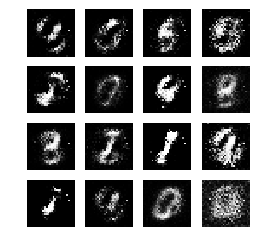

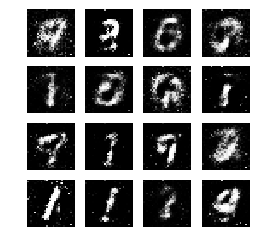

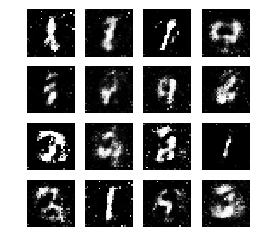

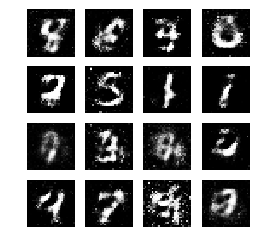

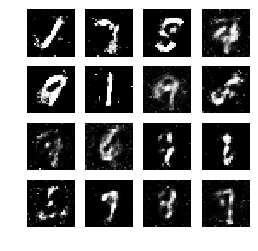

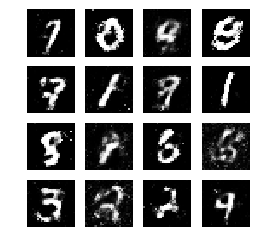

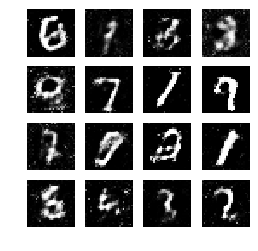

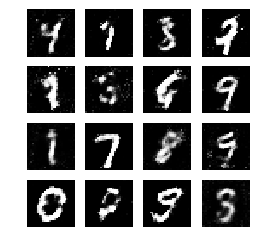

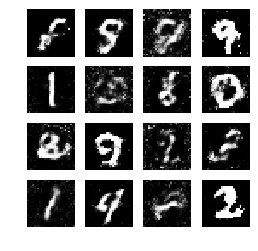

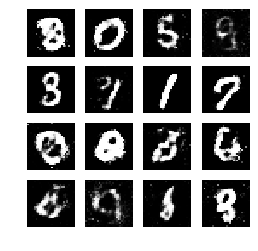

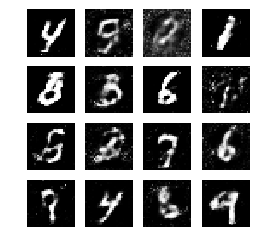

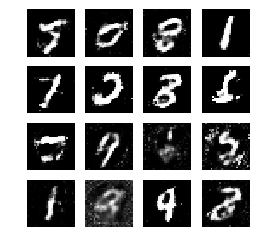

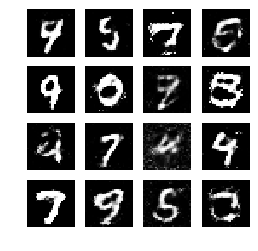

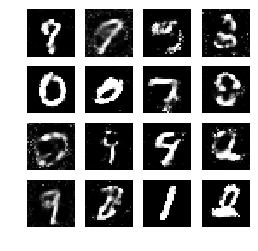

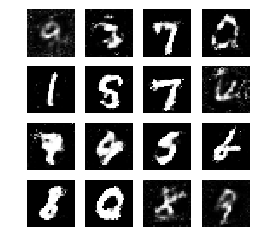

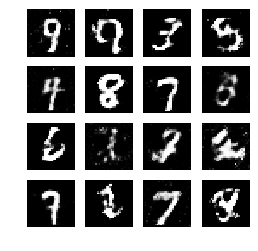

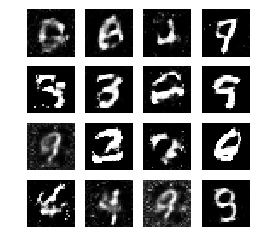

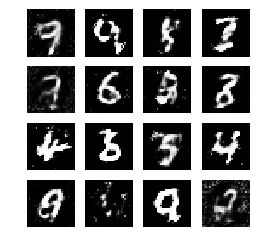

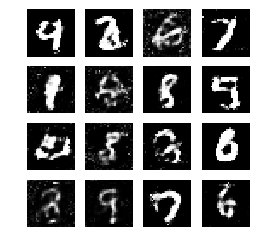

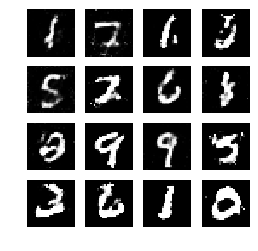

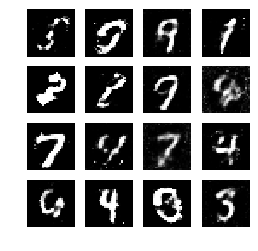

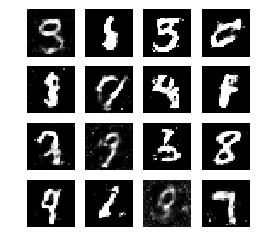

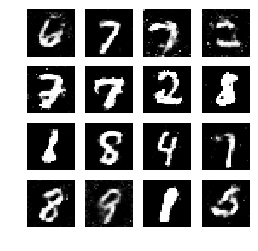

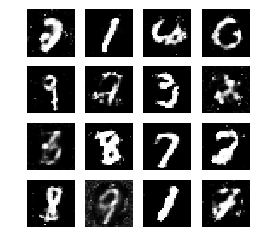

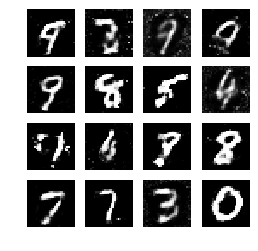

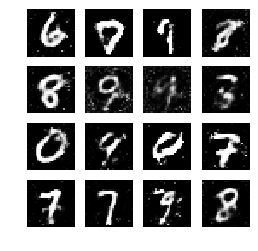

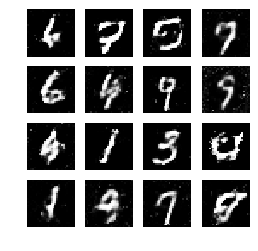

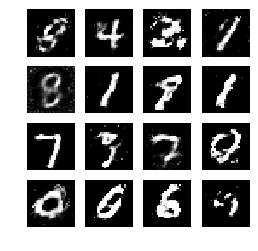

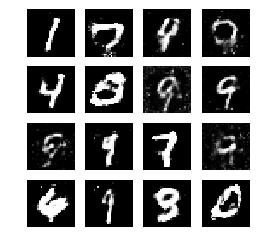

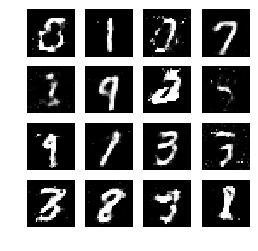

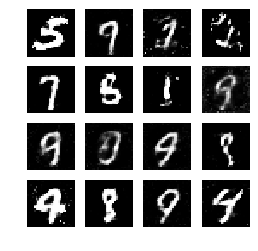

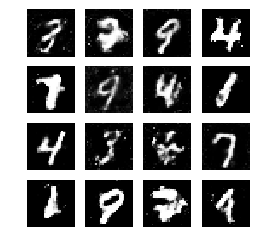

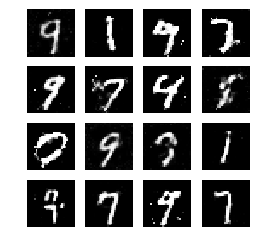

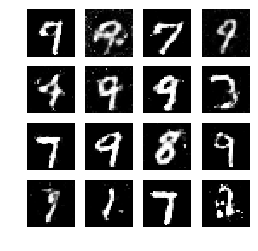

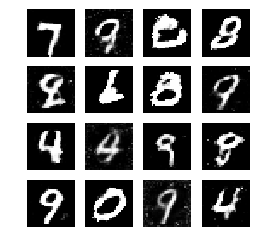

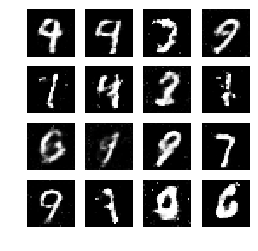

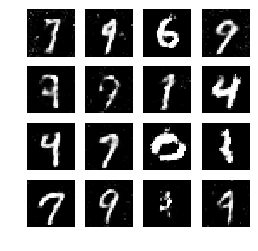

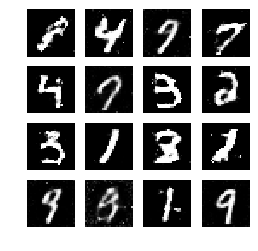

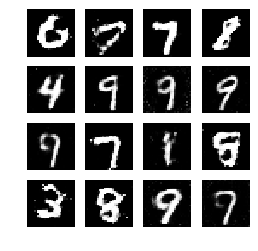

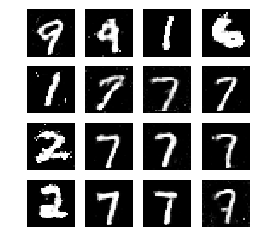

In [0]:
iterations = 200000
batch_size = 128
sample_interval = 5000
train_freeze_discriminator(iterations, batch_size, sample_interval)

#### Freeze discriminator half of time

In [ ]:
def train(interations, batch_size, sample_interval):
    losses = []
    accuracies = []
    iteration_checkpoints = []
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train / 127.5 - 1
    print(X_train.shape)
    X_train = np.expand_dims(X_train, axis=3)
    print(X_train.shape)
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    generator = build_generator(img_shape, z_dim)

    discriminator = build_discriminator(img_shape)
    discriminator.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

    gan = build_gan(generator, discriminator)
    gan.compile(loss='binary_crossentropy', optimizer='Adam')

    for iteration in range(interations):
    # train discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # train generator
        z = np.random.normal(0, 1, (batch_size, 100))
        discriminator.trainable = False
        g_loss = gan.train_on_batch(z, real)
    
        if(iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration+1)

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                      (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            sample_images(generator)
      

In [0]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

W0704 06:31:33.598550 139882537195392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0704 06:31:33.615137 139882537195392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0704 06:31:33.618117 139882537195392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0704 06:31:33.696851 139882537195392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0704 06:31:33.722506 139882537195392 deprecation_wrappe

(60000, 28, 28)
(60000, 28, 28, 1)


W0704 06:31:33.829307 139882537195392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5000 [D loss: 0.087890, acc.: 100.00%] [G loss: 4.588658]
10000 [D loss: 0.011051, acc.: 100.00%] [G loss: 6.819429]
15000 [D loss: 7.971192, acc.: 50.00%] [G loss: 0.000000]
20000 [D loss: 7.971192, acc.: 50.00%] [G loss: 0.000000]
25000 [D loss: 7.971192, acc.: 50.00%] [G loss: 0.000000]
30000 [D loss: 7.971192, acc.: 50.00%] [G loss: 0.000000]
35000 [D loss: 7.971192, acc.: 50.00%] [G loss: 0.000000]
40000 [D loss: 7.971192, acc.: 50.00%] [G loss: 0.000000]
45000 [D loss: 7.971192, acc.: 50.00%] [G loss: 0.000000]
50000 [D loss: 7.971192, acc.: 50.00%] [G loss: 0.000000]
55000 [D loss: 7.971192, acc.: 50.00%] [G loss: 0.000000]


KeyboardInterrupt: ignored

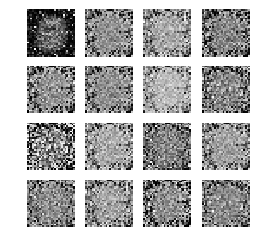

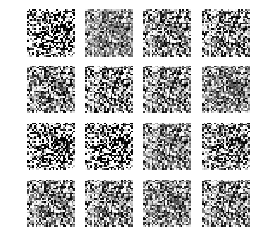

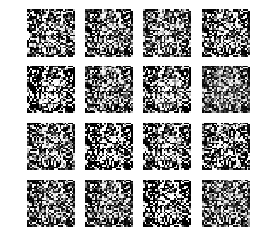

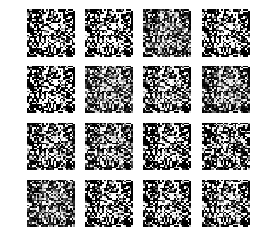

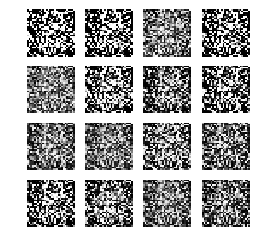

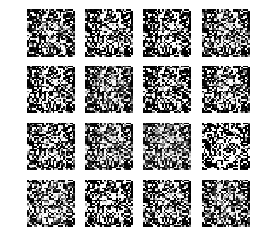

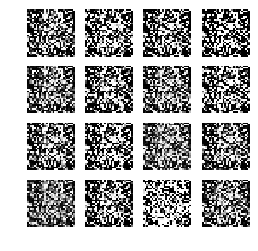

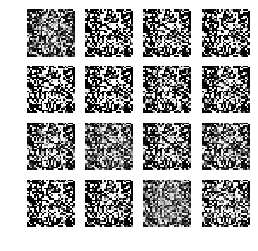

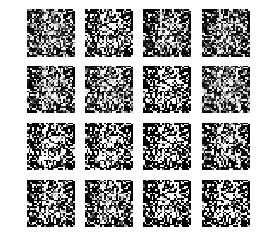

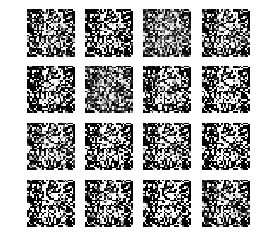

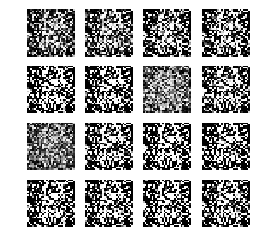

In [0]:
iterations = 200000
batch_size = 128
sample_interval = 5000
train(iterations, batch_size, sample_interval)

### DCGAN (Deep Conv GAN) 

In [0]:
from keras.layers.advanced_activations import LeakyReLU
def build_dcgan_generator(img_shape, z_dim):
    model = Sequential()
    model.add(Dense(7*7*256, input_dim=z_dim))
    model.add(Reshape((7,7,256)))
    # 7x7x256 -> 14x14x128
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    # 14x14x128 -> 14x14x64
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    # 14x14x64 -> 28x28x1
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    model.add(Activation('tanh'))

    return model

def build_dcgan_discriminator(img_shape):
    model = Sequential()

    # 28x28x1 -> 14x14x32
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same',input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.01))

    # 14x14x32 -> 7x7x64
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    # 7x7x64 -> 3x3x128
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [0]:
def build_dcgan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [0]:
def train_dcgan(interations, batch_size, sample_interval):
    losses = []
    accuracies = []
    iteration_checkpoints = []
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train / 127.5 - 1
    X_train = np.expand_dims(X_train, axis=3)
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    generator = build_dcgan_generator(img_shape, z_dim)

    discriminator = build_dcgan_discriminator(img_shape)
    discriminator.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
    discriminator.trainable = False
    dcgan = build_dcgan(generator, discriminator)
    dcgan.compile(loss='binary_crossentropy', optimizer='Adam')

    for iteration in range(interations):
        # train discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

    #     discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # train generator
        z = np.random.normal(0, 1, (batch_size, 100))
    #     discriminator.trainable = False
        g_loss = dcgan.train_on_batch(z, real)
    
        if(iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration+1)

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                      (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            sample_images(generator)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: 0.010084, acc.: 100.00%] [G loss: 5.464820]
2000 [D loss: 0.048081, acc.: 99.61%] [G loss: 4.193190]
3000 [D loss: 0.334867, acc.: 83.98%] [G loss: 1.317523]
4000 [D loss: 0.057960, acc.: 99.61%] [G loss: 6.051404]
5000 [D loss: 0.084915, acc.: 98.05%] [G loss: 4.004489]
6000 [D loss: 0.065110, acc.: 99.22%] [G loss: 3.106214]
7000 [D loss: 0.035917, acc.: 100.00%] [G loss: 4.824128]
8000 [D loss: 0.033856, acc.: 100.00%] [G loss: 4.446768]
9000 [D loss: 0.020264, acc.: 100.00%] [G loss: 3.919089]
10000 [D loss: 0.141489, acc.: 95.31%] [G loss: 4.744225]


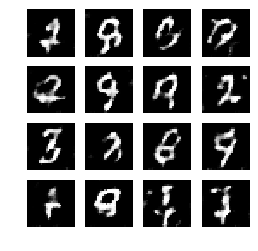

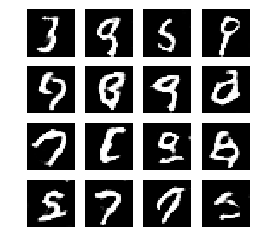

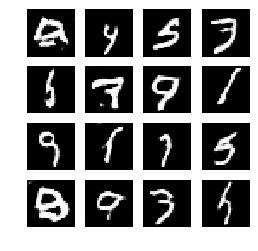

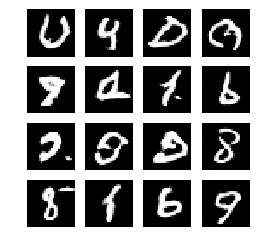

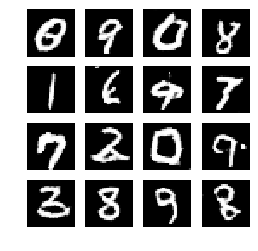

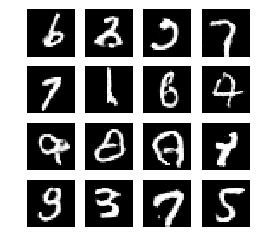

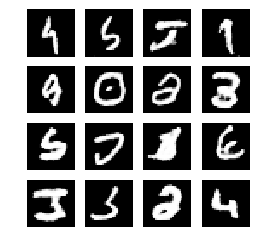

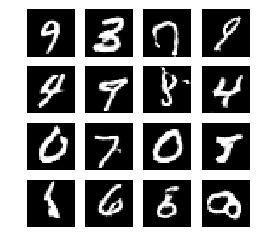

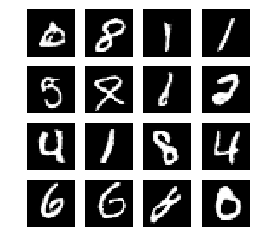

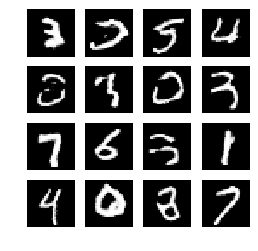

In [0]:
iterations = 10000
batch_size = 128
sample_interval = 1000
train_dcgan(iterations, batch_size, sample_interval)

### TENSORFLOW Example, DCGAN

In [0]:
def build_generator(z_dim):
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(z_dim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7,7,256)))
    assert model.output_shape == (None,7,7,256)

    model.add(Conv2DTranspose(128, (5,5), padding='same', strides=1, use_bias=False))
    assert model.output_shape == (None,7,7,128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5,5), padding='same', strides=2, use_bias=False))
    assert model.output_shape == (None,14,14,64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5,5), padding='same', strides=2, use_bias=False, activation='tanh'))
    assert model.output_shape == (None,28,28,1)

    return model

In [0]:
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (5,5), padding='same', strides=2))
    model.add(LeakyReLU())
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (5,5), padding='same', strides=2))
    model.add(LeakyReLU())
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1))
    return model

In [0]:
def generator_loss(generator_output):
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(generator_output), generator_output)

def discriminator_loss(real_output, fake_output):
    real_loss = tf.losses.sigmoid_cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.losses.sigmoid_cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [0]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
  
EPOCHS = 50
z_dim = 100
num_examples_to_generate = 16
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
def train_step(images, generator, discriminator, noise_dim=100):
 # generating noise from a normal distribution
    noise = tf.random_normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    generated_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(generated_output)
    disc_loss = discriminator_loss(real_output, generated_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))

In [0]:
def train(dataset, epochs, z_dim=100):
    generator = build_generator(z_dim)
    discriminator = build_discriminator()
  
    for ep in range(epochs):
        start = time.time()
        for images in dataset:
            train_step(images, generator, discriminator, noise_dim=z_dim)
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                   ep + 1,
                                   random_vector_for_generation)
    
    # saving (checkpoint) the model every 15 epochs
        print ('Time taken for epoch {} is {} sec'.format(ep + 1,
                                                      time.time()-start))
  # generating after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           random_vector_for_generation)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # make sure the training parameter is set to False because we
  # don't want to train the batchnorm layer when doing inference.
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))
  
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [0]:

%%time
train(train_dataset, EPOCHS)

TypeError: ignored